In [1]:
import os
import numpy as np
import anndata
import re
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import csv
import scanpy as sc
import json
import scvi
import glob
import seaborn as sns
import copy
import random
import scipy.sparse as sp_sparse
import scipy.stats as sp_stats
from datetime import datetime
from joblib import parallel_backend
from joblib import Parallel, delayed
from igraph import *
import warnings
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as scores
import pickle as pkl

import yaml
current_script_dir = os.getcwd()
config_file_path = os.path.abspath(os.path.join(current_script_dir, 'SEA-AD_utils/config/params.yaml'))
with open(config_file_path, 'r') as file:
    params = yaml.safe_load(file)

import sys
sys.path.insert(0, params['cell_path']) # Path to cell-tools

import cell_tools.model as cellmodel # import scvi_self.model as scvimodel
import cell_tools.run as cellrun # import scvi_self.run as scvirun
import cell_tools.tool as celltl # import scvi_self.tool as scvitl


%matplotlib inline

warnings.filterwarnings("ignore")

/home/aditi.chandrashekar/miniconda3/envs/cell-tools/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load data

In [2]:
adata = sc.read_h5ad(filename=params['data']['balanced_path'])

In [3]:
adata.obs["celltype"] = adata.obs["Supertype"]
adata.obs["batch"] = adata.obs["Donor ID"]

num_types = adata.obs["celltype"].unique().size
id2type = dict(enumerate(adata.obs["celltype"].cat.categories))
celltypes = adata.obs["celltype"].unique()
celltype_id_labels = adata.obs["celltype"].astype("category").cat.codes.values
adata.obs["celltype_id"] = celltype_id_labels
adata.obs["batch_id"] = adata.obs["batch"].cat.codes.values
adata.var["gene_name"] = adata.var.index.tolist()

# get high variance genes
sc.pp.highly_variable_genes(adata, n_top_genes=4000, flavor="cell_ranger", batch_key="batch")
adata = adata[:, adata.var["highly_variable"]]

In [4]:
adata.X.shape

(139000, 4000)

In [5]:
donors = pd.DataFrame(adata.obs[["Overall AD neuropathological Change", "Donor ID"]]).drop_duplicates()

In [6]:
donors["Overall AD neuropathological Change"].value_counts()
# Revised:
#  - Split 80:20 within each celltype

Overall AD neuropathological Change
High            42
Intermediate    21
Low             12
Not AD           9
Reference        5
Name: count, dtype: int64

In [7]:
adata.obs["Donor ID"].value_counts()

Donor ID
H19.30.001    5221
H18.30.002    3248
H19.33.004    3204
H19.30.002    3157
H20.33.005    2661
              ... 
H21.33.046     592
H20.33.036     575
H21.33.034     441
H20.33.038     339
H21.33.020     193
Name: count, Length: 89, dtype: int64

In [8]:
adata.obs["Donor ID"]

exp_component_name
CATCAAGTCGGATACT-L8TX_210729_01_G12-1153814338                          H21.33.035
TGCTGAAAGCGATCGA-L8TX_210415_01_E11-1153814186                          H21.33.007
AAGCCATGTGATATAG-LKTX_191204_01_F01-1156636535                          H19.30.001
TCGATTTGTCGTGATT-L8TX_210715_01_D05-1153814295                          H20.33.032
CGCCAGATCAACCTTT-L8TX_210722_01_B07-1153814297                          H20.33.034
                                                                           ...    
TTCATGTTCAGTCACA-L8TX_210430_01_C04-1142430413_aug_2cells_comb_814-1    H20.33.001
ATCGCCTAGTCTGCAT-L8TX_210430_01_D05-1142430407_aug_2cells_comb_815-1    H20.33.025
CCGAACGAGAGTCTGG-L8TX_210430_01_C04-1142430413_aug_2cells_comb_816-1    H20.33.001
GTGAGGATCACTCCGT-L8TX_201030_01_B12-1142430231_aug_2cells_comb_817-1    H20.33.015
CGCCAGAAGGTACCTT-L8TX_210729_01_C12-1153814340_aug_2cells_comb_818-1    H21.33.034
Name: Donor ID, Length: 139000, dtype: category
Categories (89, obje

In [9]:
list(adata.obs.keys())

['sample_id',
 'Neurotypical reference',
 'Donor ID',
 'Organism',
 'Brain Region',
 'Sex',
 'Gender',
 'Age at Death',
 'Race (choice=White)',
 'Race (choice=Black/ African American)',
 'Race (choice=Asian)',
 'Race (choice=American Indian/ Alaska Native)',
 'Race (choice=Native Hawaiian or Pacific Islander)',
 'Race (choice=Unknown or unreported)',
 'Race (choice=Other)',
 'specify other race',
 'Hispanic/Latino',
 'Highest level of education',
 'Years of education',
 'PMI',
 'Fresh Brain Weight',
 'Brain pH',
 'Overall AD neuropathological Change',
 'Thal',
 'Braak',
 'CERAD score',
 'Overall CAA Score',
 'Highest Lewy Body Disease',
 'Total Microinfarcts (not observed grossly)',
 'Total microinfarcts in screening sections',
 'Atherosclerosis',
 'Arteriolosclerosis',
 'LATE',
 'Cognitive Status',
 'Last CASI Score',
 'Interval from last CASI in months',
 'Last MMSE Score',
 'Interval from last MMSE in months',
 'Last MOCA Score',
 'Interval from last MOCA in months',
 'APOE Genotype

In [10]:
adata.obs["Subclass_refined"] = adata.obs["Subclass"]
adata.obs["Subclass_refined"] = adata.obs["Subclass_refined"].cat.add_categories(["Astrocyte_A", "Astrocyte_B", "Astrocyte_C", "Microglia-PVM_A", "Microglia-PVM_B", "Microglia-PVM_C", "OPC_A", "OPC_B", "Oligodendrocyte_A", "Oligodendrocyte_B"])

# Divide Astrocyte subclass
adata.obs.loc[adata.obs["Supertype"] == "Astro_1", "Subclass_refined"] = "Astrocyte_A"
adata.obs.loc[adata.obs["Supertype"] == "Astro_3", "Subclass_refined"] = "Astrocyte_A"
adata.obs.loc[adata.obs["Supertype"] == "Astro_2", "Subclass_refined"] = "Astrocyte_B"
adata.obs.loc[adata.obs["Supertype"] == "Astro_4", "Subclass_refined"] = "Astrocyte_B"
adata.obs.loc[adata.obs["Supertype"] == "Astro_5", "Subclass_refined"] = "Astrocyte_C"
adata.obs.loc[adata.obs["Supertype"] == "Astro_6-SEAAD", "Subclass_refined"] = "Astrocyte_C"
adata.obs["Subclass_refined"] = adata.obs["Subclass_refined"].cat.remove_categories(["Astrocyte"])

# Divide Microglia PVM subclass
adata.obs.loc[adata.obs["Supertype"] == "Lymphocyte", "Subclass_refined"] = "Microglia-PVM_A"
adata.obs.loc[adata.obs["Supertype"] == "Micro-PVM_1", "Subclass_refined"] = "Microglia-PVM_A"
adata.obs.loc[adata.obs["Supertype"] == "Micro-PVM_2", "Subclass_refined"] = "Microglia-PVM_A"
adata.obs.loc[adata.obs["Supertype"] == "Micro-PVM_2_1-SEAAD", "Subclass_refined"] = "Microglia-PVM_B"
adata.obs.loc[adata.obs["Supertype"] == "Micro-PVM_2_3-SEAAD", "Subclass_refined"] = "Microglia-PVM_B"
adata.obs.loc[adata.obs["Supertype"] == "Micro-PVM_3-SEAAD", "Subclass_refined"] = "Microglia-PVM_C"
adata.obs.loc[adata.obs["Supertype"] == "Micro-PVM_4-SEAAD", "Subclass_refined"] = "Microglia-PVM_C"
adata.obs.loc[adata.obs["Supertype"] == "Monocyte", "Subclass_refined"] = "Microglia-PVM_C"
adata.obs["Subclass_refined"] = adata.obs["Subclass_refined"].cat.remove_categories(["Microglia-PVM"])

# Divide OPC subclass
adata.obs.loc[adata.obs["Supertype"] == "OPC_1", "Subclass_refined"] = "OPC_A"
adata.obs.loc[adata.obs["Supertype"] == "OPC_2", "Subclass_refined"] = "OPC_A"
adata.obs.loc[adata.obs["Supertype"] == "OPC_2_1-SEAAD", "Subclass_refined"] = "OPC_B"
adata.obs.loc[adata.obs["Supertype"] == "OPC_2_2-SEAAD", "Subclass_refined"] = "OPC_B"
adata.obs["Subclass_refined"] = adata.obs["Subclass_refined"].cat.remove_categories(["OPC"])

# Divide Oligodendrocyte subclass
adata.obs.loc[adata.obs["Supertype"] == "Oligo_1", "Subclass_refined"] = "Oligodendrocyte_A"
adata.obs.loc[adata.obs["Supertype"] == "Oligo_2", "Subclass_refined"] = "Oligodendrocyte_A"
adata.obs.loc[adata.obs["Supertype"] == "Oligo_2_1-SEAAD", "Subclass_refined"] = "Oligodendrocyte_B"
adata.obs.loc[adata.obs["Supertype"] == "Oligo_3", "Subclass_refined"] = "Oligodendrocyte_B"
adata.obs.loc[adata.obs["Supertype"] == "Oligo_4", "Subclass_refined"] = "Oligodendrocyte_B"
adata.obs["Subclass_refined"] = adata.obs["Subclass_refined"].cat.remove_categories(["Oligodendrocyte"])

# adata.obs.loc[adata.obs["Subclass_refined"] == "Oligodendrocyte_B", "Supertype"].value_counts()[:10]

In [4]:
params["results"]["runfiles"] = '/allen/programs/celltypes/workgroups/rnaseqanalysis/XGKM/playground/Aditi/outputs/runfiles/'
grouping = adata.obs.loc[:, ["Subclass", "Supertype"]].drop_duplicates().sort_values(by="Supertype")
grouping["Subclass"] = grouping["Subclass"].astype("category")
grouping["subclass_codes"] = grouping["Subclass"].cat.codes
grouping = grouping["subclass_codes"].to_numpy()

# if os.path.exists(os.path.join(params["results"]["runfiles"], "input", "random_subclass_grouping.npy")) == False:
random_grouping = np.random.choice(grouping, len(grouping), replace=False)
np.save(os.path.join(params["results"]["runfiles"], "input", "random_subclass_grouping.npy"), random_grouping)
# else:
#     random_grouping = np.load(os.path.join(params["results"]["runfiles"], "input", "random_subclass_grouping.npy"))

# if os.path.exists(os.path.join(params["results"]["runfiles"], "input", "scrambled_supertypes.csv")) == False:
adata.obs["supertypes_scrambled"] = np.random.choice(adata.obs["Supertype"], len(adata.obs["Supertype"]), replace=False)
adata.obs["supertypes_scrambled"].to_csv(os.path.join(params["results"]["runfiles"], "input", "scrambled_supertypes.csv"))

# else:
#     tmp = pd.read_csv(os.path.join(params["results"]["runfiles"], "input", "scrambled_supertypes.csv"), index_col=0)
#     adataref.obs = adata_ref.obs.merge(tmp["cluster_scrambled"], left_index=True, right_index=True, how="left")

## Run CELL

In [5]:
model_path = params["results"]["model_results"]
cell_model_path = os.path.join(model_path, "cell_cg_GELU")
batch_size = 128
max_epochs = 500
cell_model, cell_kwargs = cellrun.run_CELL(adata, 
                                           cell_model_path, 
                                           batch_key="method",
                                           categorical_covariate_keys=["library_prep"],
                                           batch_size=batch_size,
                                           max_epochs=max_epochs,
                                           use_labels_groups=True,
                                           labels_groups=grouping,
                                          )

INFO     File                                                                                                      
         /allen/programs/celltypes/workgroups/rnaseqanalysis/XGKM/playground/Aditi/outputs/models/cell_cg_GELU/mode
         l.pt already downloaded                                                                                   


Available Losses: ['Adversarial_loss_step', 'train_loss_step', 'validation_loss', 'elbo_validation', 'reconstruction_loss_validation', 'kl_local_validation', 'kl_global_validation', 'Adversarial_loss_epoch', 'elbo_train', 'reconstruction_loss_train', 'kl_local_train', 'kl_global_train', 'train_loss_epoch']


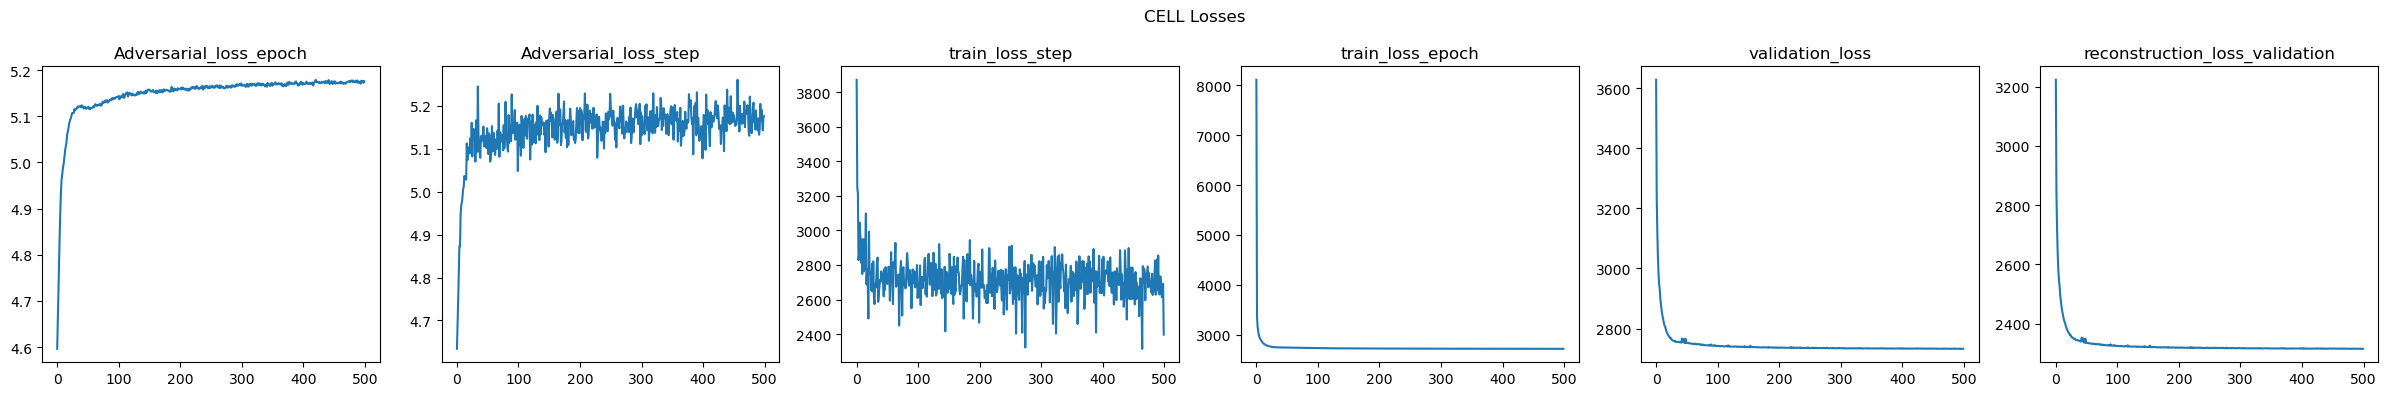

In [6]:
print(f'Available Losses: {list(cell_model.history_.keys())}')
cell_history = cell_model.history_
metrics_to_plot = ['Adversarial_loss_epoch', 'Adversarial_loss_step', 'train_loss_step', 'train_loss_epoch', 'validation_loss', 'reconstruction_loss_validation']
fig, axs = plt.subplots(1, len(metrics_to_plot), figsize=(len(metrics_to_plot)*4, 4))
for i, metric in enumerate(metrics_to_plot):
    axs[i].plot(cell_history[metric])
    axs[i].set_title(metric)
fig.suptitle('CELL Losses')
plt.tight_layout()


## Plot Latents

INFO     File                                                                                                      
         /allen/programs/celltypes/workgroups/rnaseqanalysis/XGKM/playground/Aditi/outputs/models/cell_cg_GELU/mode
         l.pt already downloaded                                                                                   
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


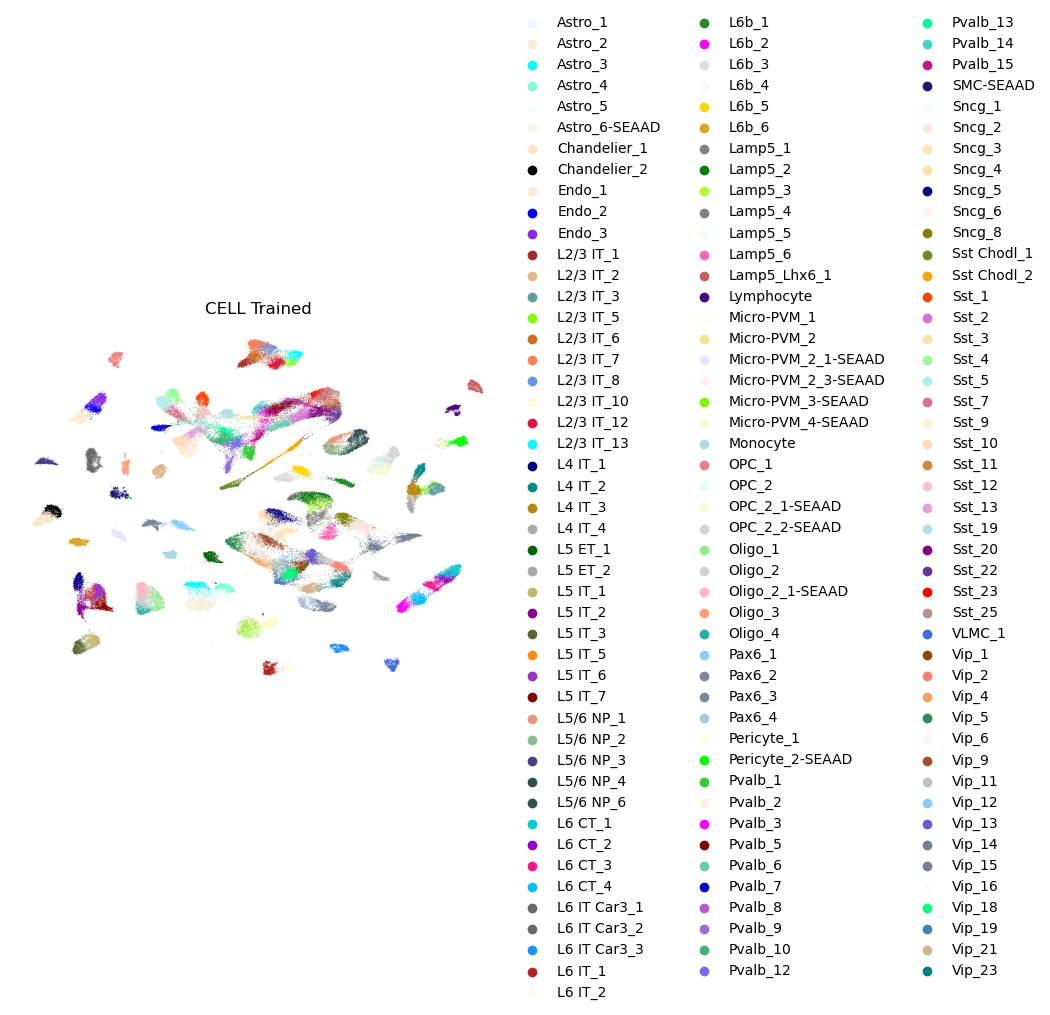

In [7]:
if os.path.exists(os.path.join(cell_model_path, "CELL.h5ad")) and os.path.exists(os.path.join(cell_model_path, 'CELL_umap.pkl')):
        print("CELL model has been clustered before!" )
        adata_CELL = sc.read_h5ad(filename=os.path.join(cell_model_path, "CELL.h5ad"))
        umap_model = pkl.load(open(os.path.join(cell_model_path, 'CELL_umap.pkl'),'rb'))
else:
        cell_model = cellmodel.CELL.load(cell_model_path, adata)
        adata_CELL = adata.copy()
        latent = cell_model.get_latent_representation(adata_CELL)
        adata_CELL.obsm["CELL"] = latent
        sc.pp.neighbors(adata_CELL, use_rep="CELL") # Using latent representation to form neighbors
        _, umap_model = celltl.umap(adata_CELL, min_dist=0.3, method='rapids')
        adata_CELL.write_h5ad(filename=os.path.join(cell_model_path, "CELL.h5ad"))
        pkl.dump(umap_model, open(os.path.join(cell_model_path, 'CELL_umap.pkl'), 'wb'))

sc.pl.umap(
        adata_CELL,
        color=["Supertype"], 
        palette = list(mpl.colors.CSS4_COLORS.values()), 
        frameon=False,
        title="CELL Trained"
        ) # show the cell before classification

## Run CELLBLAST Model

In [8]:
# Make column for train vs val
def create_train_test_adata(adata, perc_train=0.8, splitby="Supertype", seed=42, output_train_path=None, output_val_path=None):
    """
    Splits an AnnData object into training and validation sets based on the specified category.
    Designed for SEA-AD dataset.

    Parameters:
    adata (anndata.AnnData): The input AnnData object containing single-cell data.
    perc_train (float, optional): The proportion of cells to include in the training set (default is 0.8).
    splitby (str, optional): The column name in adata.obs to split by (default is "Supertype").
    seed (int, optional): The random seed for reproducibility (default is 42).

    Returns:
    train_adata (anndata.AnnData): The training set AnnData object.
    val_adata (anndata.AnnData): The validation set AnnData object.
    """
    train_indices = []
    val_indices = []

    if seed is not None:
        np.random.seed(seed)

    # create random split for each category
    for category in adata.obs[splitby].unique():
        adata_category = adata.obs[adata.obs[splitby] == category]
        num_train = int(perc_train*len(adata_category))
        indices = list(adata_category.index)
        np.random.shuffle(indices)
        train_indices.extend(indices[:num_train])
        val_indices.extend(indices[num_train:])

    train_adata = adata[train_indices, :].copy()
    val_adata = adata[val_indices, :].copy()

    print("Train size:", train_adata.shape)
    print("Validation size:", val_adata.shape)

    if output_train_path is not None: train_adata.write_h5ad(filename=output_train_path)
    if output_val_path is not None: val_adata.write_h5ad(filename=output_val_path)

    return train_adata, val_adata, train_indices, val_indices

train_adata, val_adata, train_indices, val_indices = create_train_test_adata(adata)

Train size: (111200, 4000)
Validation size: (27800, 4000)


In [9]:
adata.obs["train"] = False
adata.obs.loc[train_indices, "train"] = True
adata.obs["train"] = adata.obs["train"].astype('category')

In [10]:
cellblast_max_epochs = 10
cellblast_batch_size = 128
label_model_path = os.path.join(model_path, "cell_cg_blast_cg_GELU")
blast_kwargs = cellrun.run_CELLBLAST(
        adata=adata,
        model_dir = cell_model_path,
        label_model_dir = label_model_path,
        CELL_kwargs = cell_kwargs,
        batch_key="method",
        categorical_covariate_keys=["library_prep"],
        splitby="train",
        labels_key="Supertype",
        cellblast_max_epochs = 10,
        cellblast_batch_size = 128,
        verbose=True,
        use_labels_groups=True,
        labels_groups=grouping,
    )

RUNNING CELLBLAST
INFO     File                                                                                                      
         /allen/programs/celltypes/workgroups/rnaseqanalysis/XGKM/playground/Aditi/outputs/models/cell_cg_GELU/mode
         l.pt already downloaded                                                                                   


Held out: False
CELLBLAST model: /allen/programs/celltypes/workgroups/rnaseqanalysis/XGKM/playground/Aditi/outputs/models/cell_cg_blast_cg_GELU_0 has been evaluated!
Held out: True
CELLBLAST model: /allen/programs/celltypes/workgroups/rnaseqanalysis/XGKM/playground/Aditi/outputs/models/cell_cg_blast_cg_GELU_1 has been evaluated!


In [11]:
cellblast = cellmodel.CELLBLAST.load(label_model_path+"_0", adata)

INFO     File                                                                                                      
         /allen/programs/celltypes/workgroups/rnaseqanalysis/XGKM/playground/Aditi/outputs/models/cell_cg_blast_cg_
         GELU_0/model.pt already downloaded                                                                        


Available Losses: ['Adversarial_loss_step', 'train_loss_step', 'validation_loss', 'elbo_validation', 'reconstruction_loss_validation', 'kl_local_validation', 'kl_global_validation', 'classification_loss_validation', 'contrastive_loss_validation', 'Adversarial_loss_epoch', 'train_loss_epoch', 'elbo_train', 'reconstruction_loss_train', 'kl_local_train', 'kl_global_train', 'classification_loss_train', 'contrastive_loss_train']


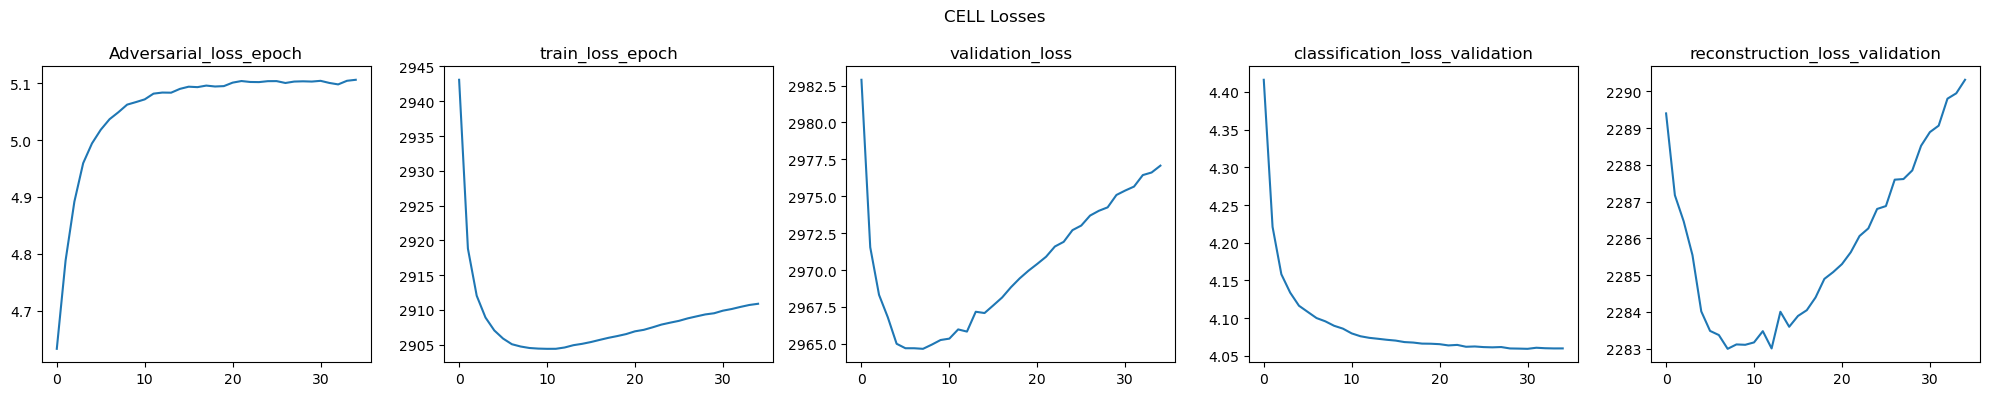

In [12]:
cell_history = cellblast.history_
print(f'Available Losses: {list(cell_history.keys())}')
metrics_to_plot = ['Adversarial_loss_epoch', 'train_loss_epoch', 'validation_loss', 'classification_loss_validation', 'reconstruction_loss_validation']
fig, axs = plt.subplots(1, len(metrics_to_plot), figsize=(len(metrics_to_plot)*4, 4))
for i, metric in enumerate(metrics_to_plot):
    axs[i].plot(cell_history[metric])
    axs[i].set_title(metric)
fig.suptitle('CELL Losses')
plt.tight_layout()

## Plot CELLBLAST Latents

BLAST model has been clustered before!


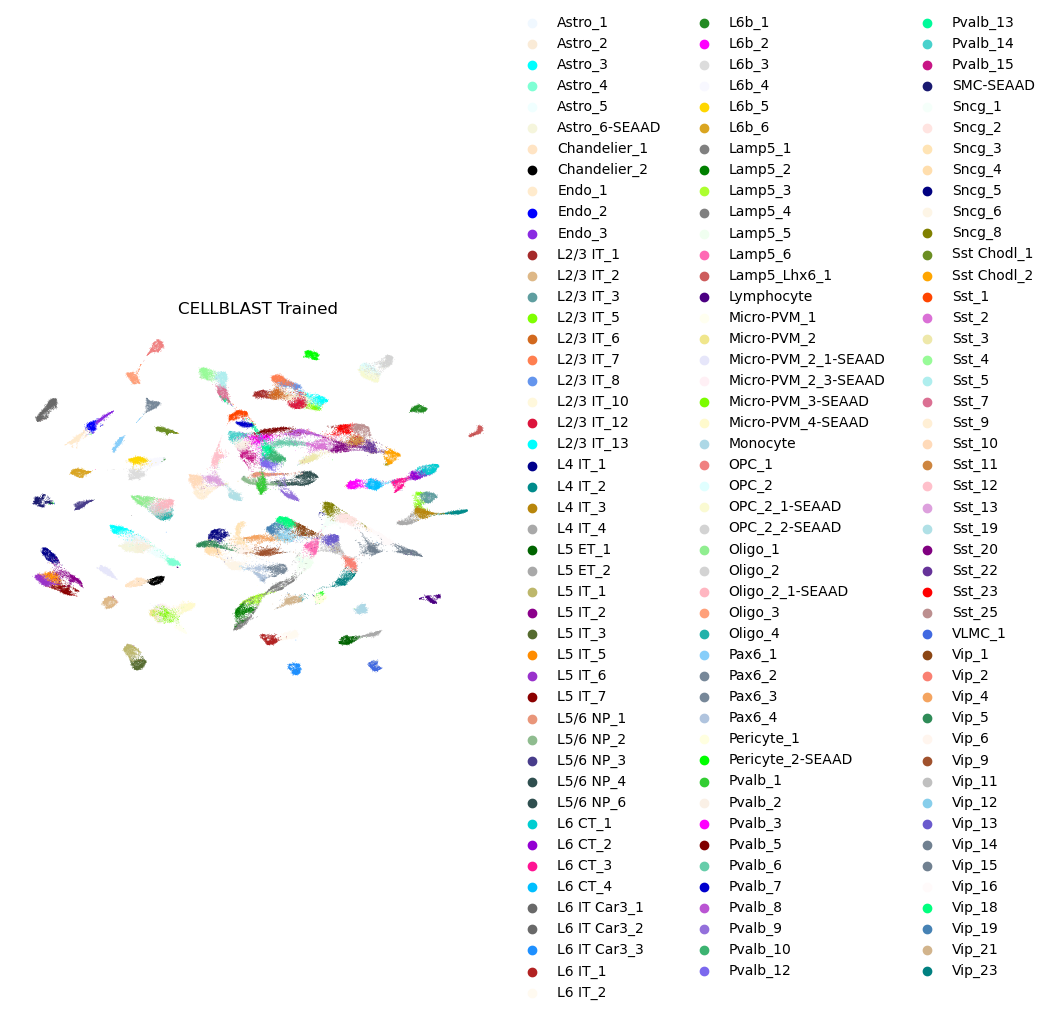

In [13]:
label_model_path_full = label_model_path+"_0"
if os.path.exists(os.path.join(label_model_path_full, "CELLBLAST.h5ad")) and os.path.exists(os.path.join(label_model_path_full, 'CELLBLAST_umap.pkl')):
        print("BLAST model has been clustered before!" )
        adata_CELLBLAST = sc.read_h5ad(filename=os.path.join(label_model_path_full, "CELLBLAST.h5ad"))
        umap_label = pkl.load(open(os.path.join(label_model_path_full, 'CELLBLAST_umap.pkl'),'rb'))
else:
        label_model = cellmodel.CELLBLAST.load(label_model_path_full, adata)
        print(label_model)
        adata_CELLBLAST = adata.copy()
        latent_CELLBLAST = label_model.get_latent_representation(adata_CELLBLAST)
        adata_CELLBLAST.obsm["CELLBLAST"] = latent_CELLBLAST
        sc.pp.neighbors(adata_CELLBLAST, use_rep="CELLBLAST") # Using latent representation to form neighbors
        _, umap_label = celltl.umap(adata_CELLBLAST, min_dist=0.3, method='rapids')
        adata_CELLBLAST.write_h5ad(filename=os.path.join(label_model_path_full, "CELLBLAST.h5ad"))
        pkl.dump(umap_label, open(os.path.join(label_model_path_full, 'CELLBLAST_umap.pkl'), 'wb'))

sc.pl.umap(
        adata_CELLBLAST,
        color=["Supertype"], 
        palette = list(mpl.colors.CSS4_COLORS.values()), 
        frameon=False,
        title="CELLBLAST Trained"
        ) # show the cell after cellblast classification



## Compute Metrics

In [14]:
models = [
    {
        "model_dir" : cell_model_path,
        "label_model_dir" : label_model_path,
        "CELL_kwargs" : cell_kwargs,
        "batch_key" : "method",
        "categorical_covariate_keys": ["library_prep"],
        "splitby": "train",
        "labels_key": "Supertype",
        "cellblast_max_epochs": 10,
        "cellblast_batch_size": 128
    }
]
results, metrics = celltl.compile_results(
    adata,
    "Supertype",
    models=models
)

KEYS:  Index(['true', 'pred'], dtype='object')


In [15]:
# print(results)
metrics = pd.DataFrame(metrics)
metrics

,label,precision,recall,f1,support,model_name
0,Astro_1,0.807868,0.883,0.843765,1000,cell_cg_blast_cg_GELU
1,Astro_2,0.853561,0.851,0.852278,1000,cell_cg_blast_cg_GELU
2,Astro_3,0.964611,0.954,0.959276,1000,cell_cg_blast_cg_GELU
3,Astro_4,0.916988,0.950,0.933202,1000,cell_cg_blast_cg_GELU
4,Astro_5,0.931522,0.857,0.892708,1000,cell_cg_blast_cg_GELU
...,...,...,...,...,...,...
134,Vip_16,0.935167,0.952,0.943508,1000,cell_cg_blast_cg_GELU
135,Vip_18,0.867514,0.956,0.909610,1000,cell_cg_blast_cg_GELU
136,Vip_19,0.946820,0.908,0.927004,1000,cell_cg_blast_cg_GELU
137,Vip_21,0.947977,0.984,0.965653,1000,cell_cg_blast_cg_GELU


In [16]:
np.mean(metrics["f1"])

0.9276649576910915

cell_cg_blast_cg_GELU


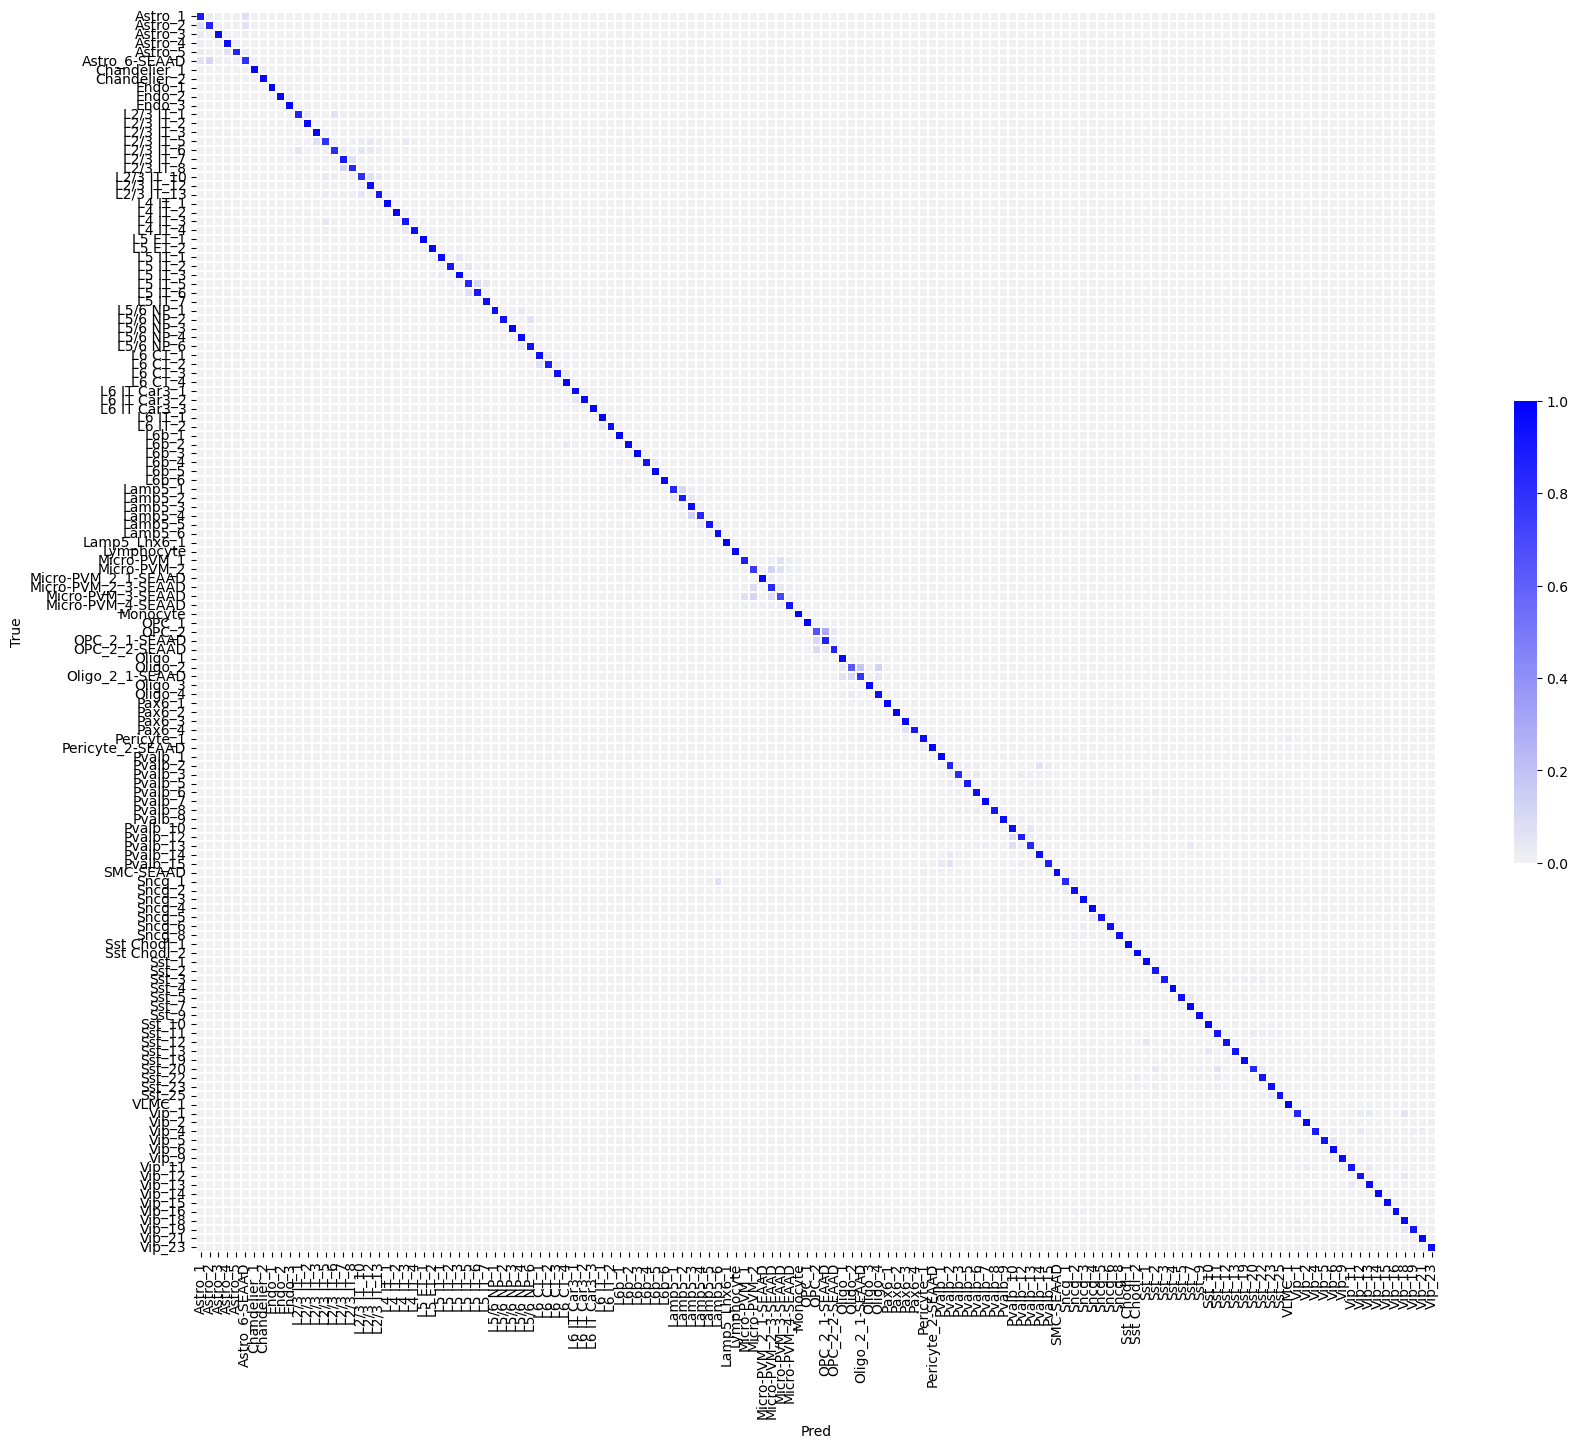

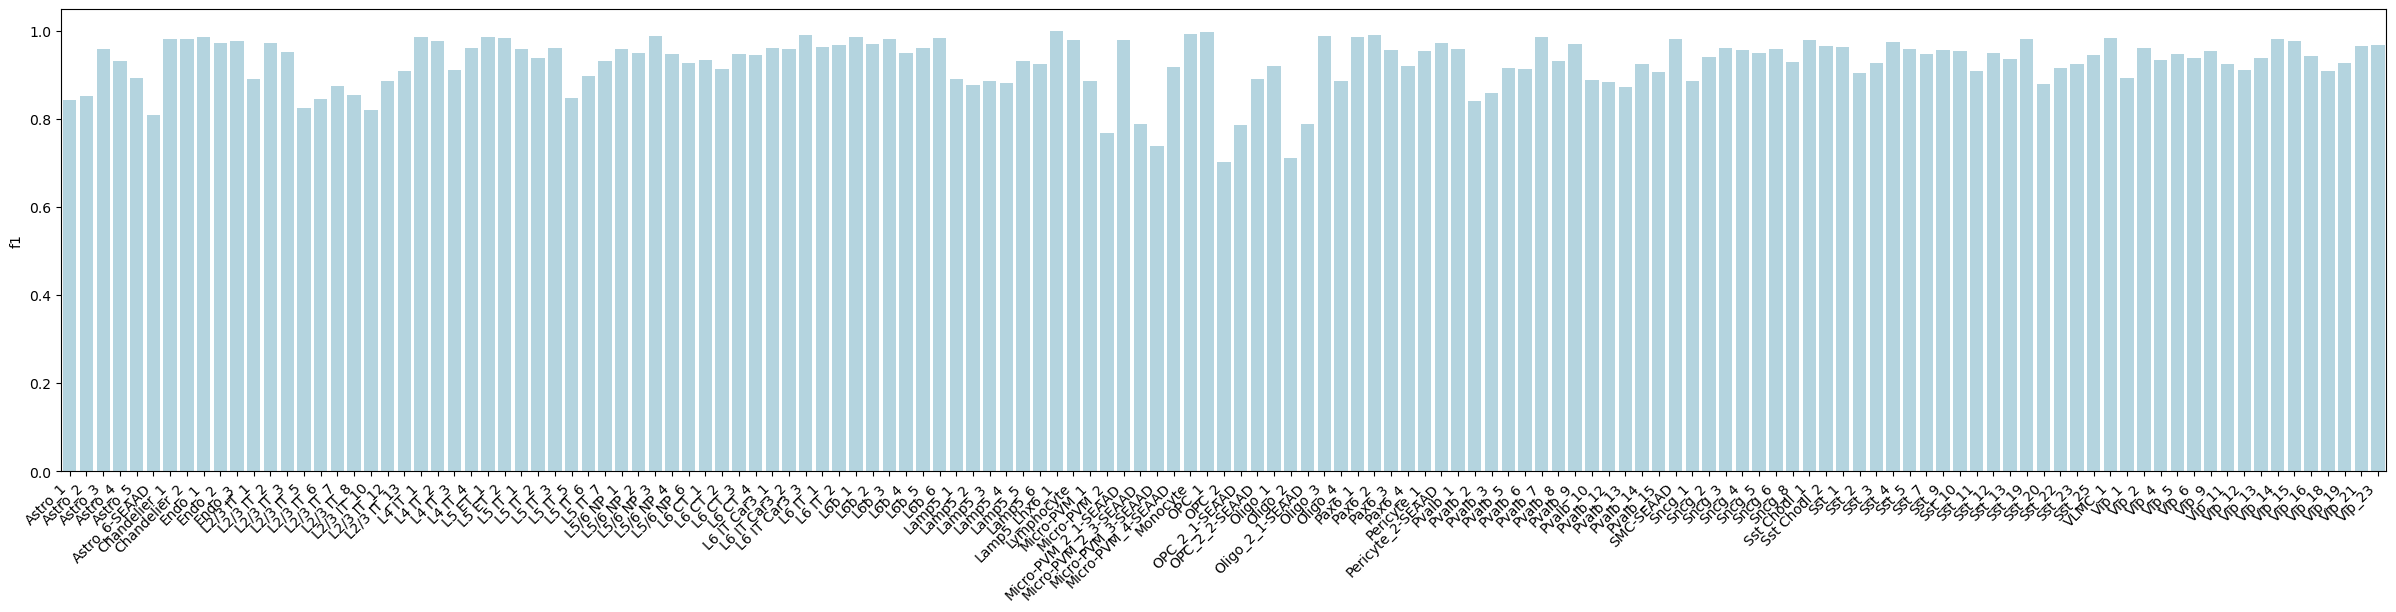

In [17]:
cf_df = celltl.plot_model_summaries(results, metrics, "Supertype")

In [25]:
cf_df

Pred,Astro_1,Astro_2,Astro_3,Astro_4,Astro_5,Astro_6-SEAAD,Chandelier_1,Chandelier_2,Endo_1,Endo_2,...,Vip_11,Vip_12,Vip_13,Vip_14,Vip_15,Vip_16,Vip_18,Vip_19,Vip_21,Vip_23
True,,,,,,,,,,,,,,,,,,,,,
Astro_1,0.903,0.0,0.009,0.000,0.011,0.077,0.0,0.0,0.0,0.0,...,0.0,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Astro_2,0.323,0.0,0.002,0.000,0.067,0.608,0.0,0.0,0.0,0.0,...,0.0,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Astro_3,0.033,0.0,0.956,0.007,0.001,0.003,0.0,0.0,0.0,0.0,...,0.0,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Astro_4,0.013,0.0,0.007,0.959,0.019,0.002,0.0,0.0,0.0,0.0,...,0.0,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Astro_5,0.025,0.0,0.004,0.075,0.865,0.031,0.0,0.0,0.0,0.0,...,0.0,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Vip_16,0.000,0.0,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,...,0.0,0.000,0.0,0.005,0.002,0.952,0.000,0.002,0.000,0.000
Vip_18,0.000,0.0,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,...,0.0,0.006,0.0,0.000,0.000,0.000,0.974,0.003,0.000,0.001
Vip_19,0.000,0.0,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,...,0.0,0.013,0.0,0.000,0.002,0.005,0.070,0.895,0.006,0.000


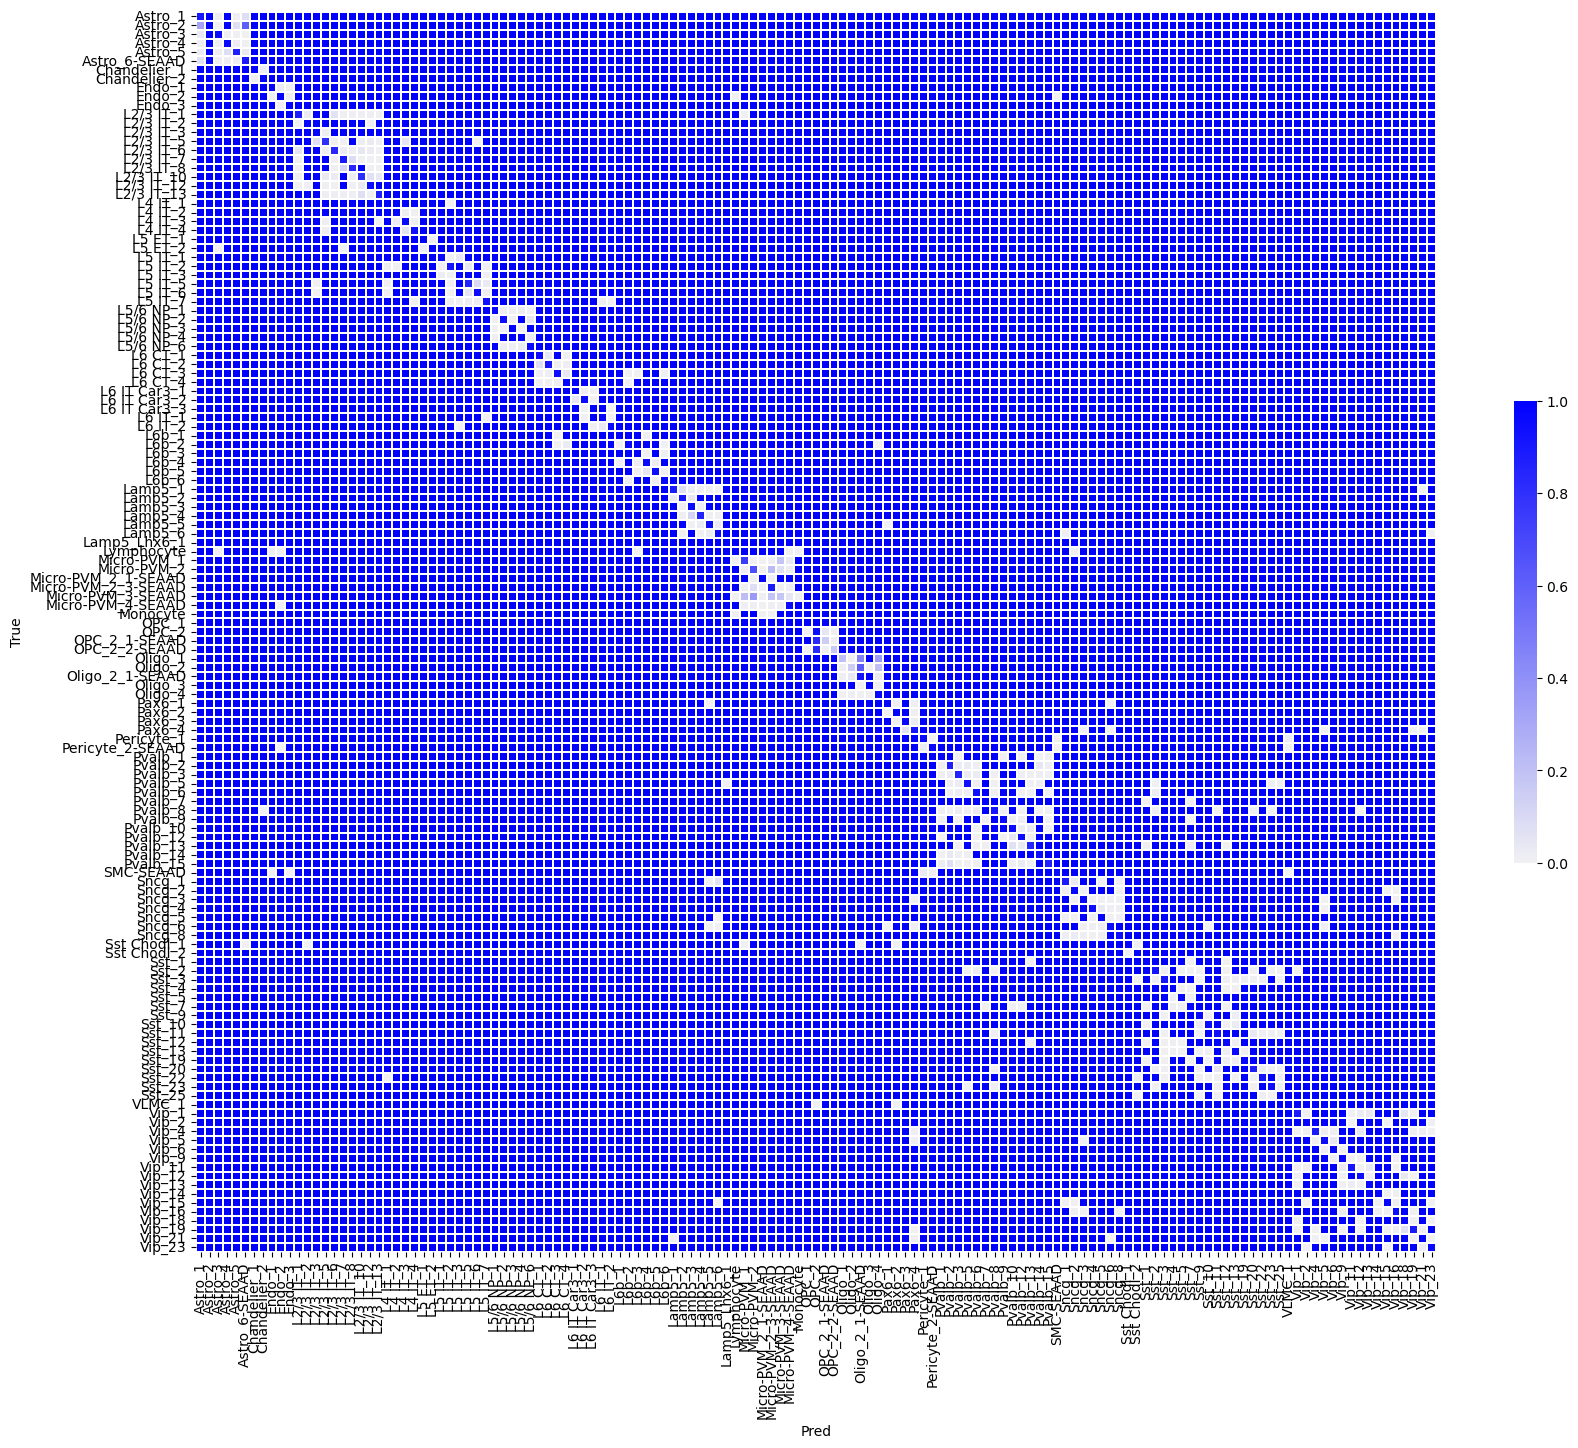

In [26]:
inv_df = cf_df.copy()
inv_df[inv_df == 0] = 1
plt.subplots(1,1,figsize=(20, 20))
ax = sns.heatmap(inv_df,
                    vmin=0,vmax=1,
                    xticklabels=True, 
                    yticklabels=True, 
                    square=True, 
                    linewidths=0.05,
                    cmap=sns.color_palette("light:b", as_cmap=True),
                    cbar_kws={'shrink': 0.3,"orientation": "vertical"})

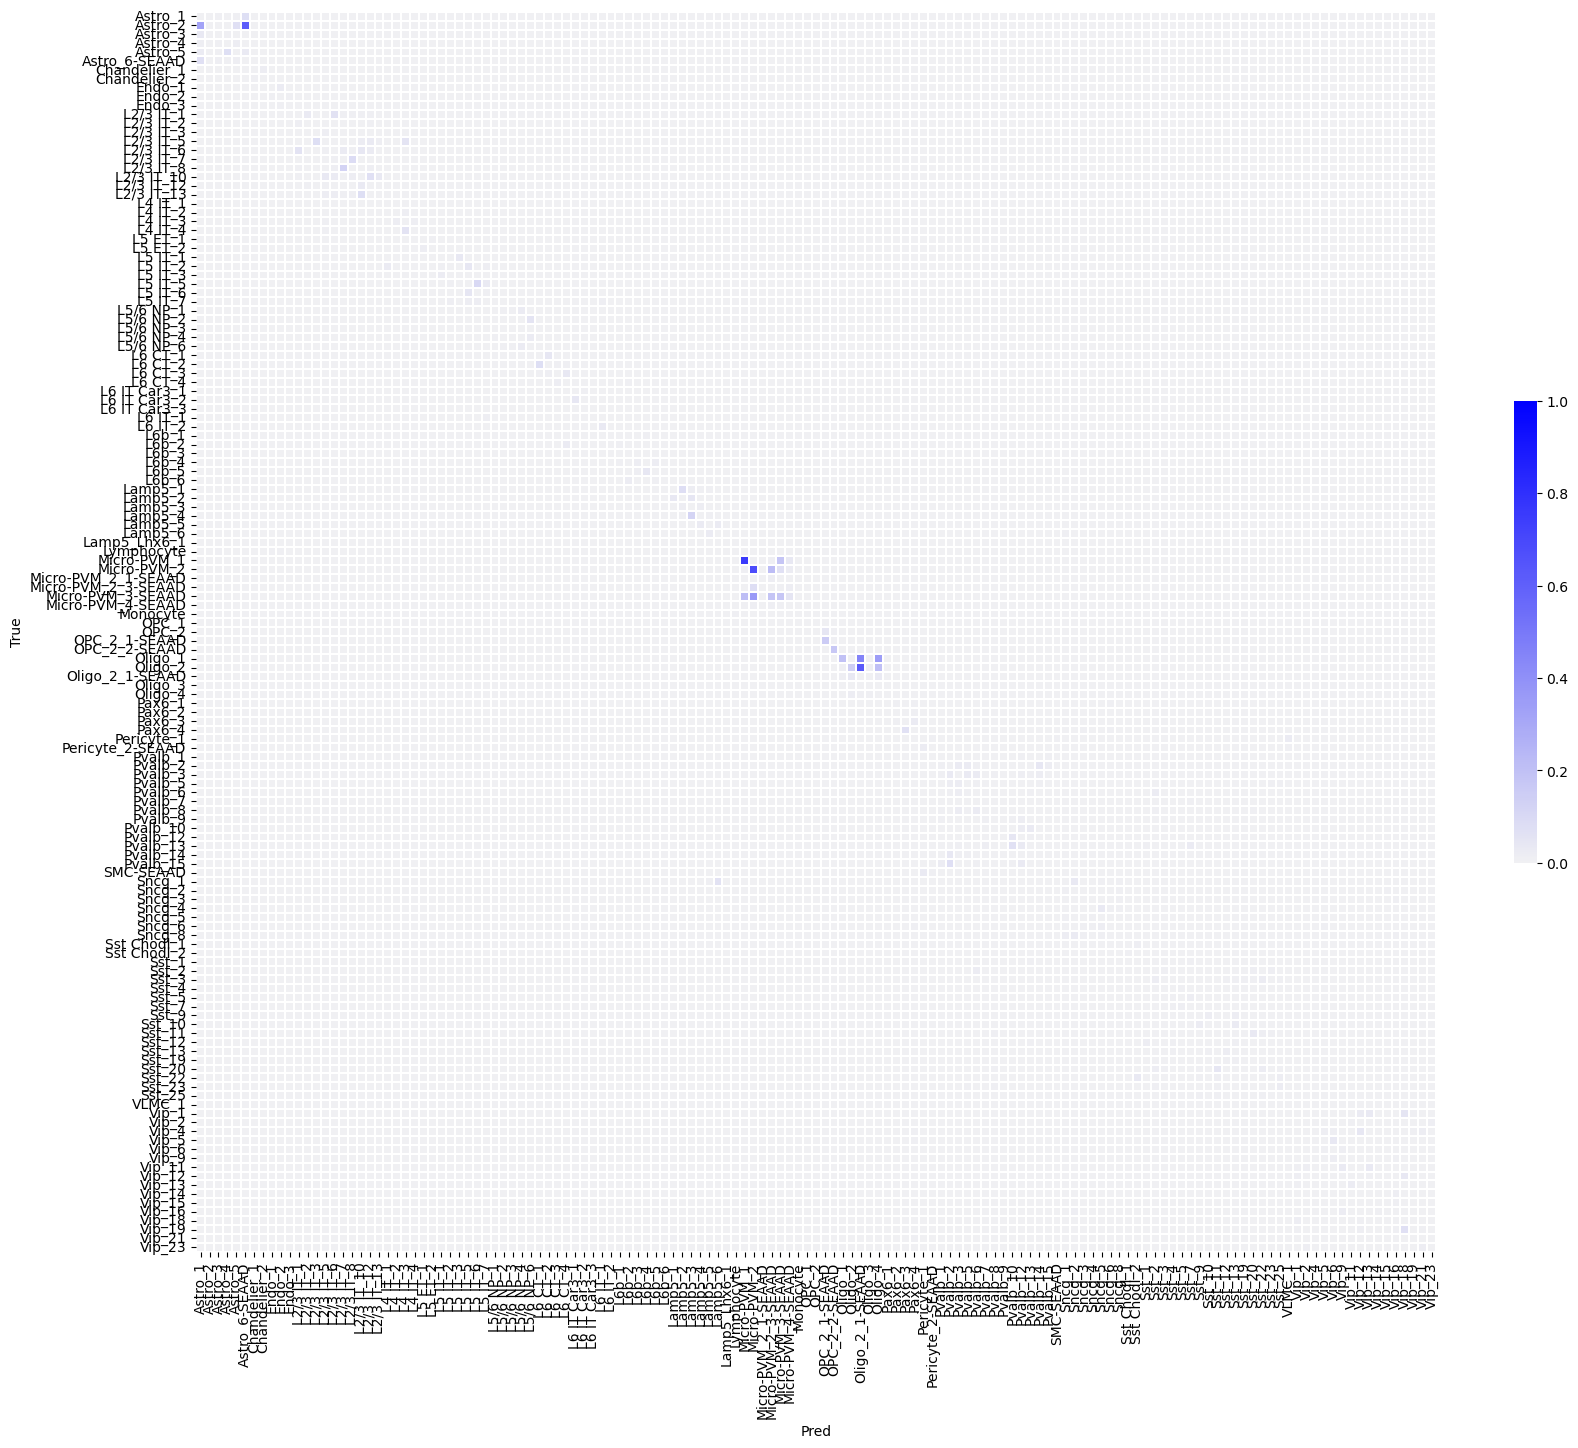

In [27]:
n_df = cf_df.copy()
n_df[n_df > 0.78] = 0
plt.subplots(1,1,figsize=(20, 20))
ax = sns.heatmap(n_df,
                    vmin=0,vmax=1,
                    xticklabels=True, 
                    yticklabels=True, 
                    square=True, 
                    linewidths=0.05,
                    cmap=sns.color_palette("light:b", as_cmap=True),
                    cbar_kws={'shrink': 0.3,"orientation": "vertical"})